Code source: https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import cv2
import os
import numpy as np 
import pandas as pd 

import sys 
!{sys.executable} -m pip install opencv-python

In [2]:
code_folder='/media/user/F/BME_400_Group_02/codes/'
data_folder='/media/user/F/BME_400_Group_02/splitted_70_20_10/'

# data loading & training

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data(data_folder+'train')
test = get_training_data(data_folder+'test')
val = get_training_data(data_folder+'val')

/tmp/ipykernel_145944/771166761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


/home/user/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

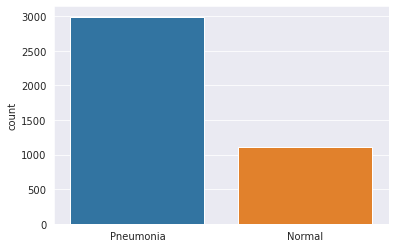

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

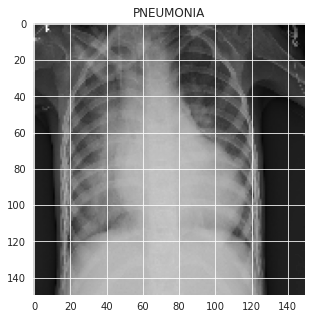

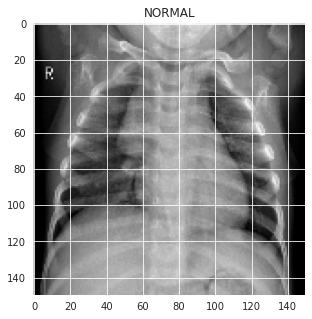

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
for i in range(np.shape(x_train)[0]):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(x_train[i])
    x_train[i]=equalized
for i in range(np.shape(x_val)[0]):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(x_val[i])
    x_val[i]=equalized

for i in range(np.shape(x_test)[0]):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(x_test[i])
    x_test[i]=equalized

In [9]:
np.shape(x_train)[0]

4099

In [10]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [11]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [0.8, 1.2], # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "Adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

2022-08-24 10:59:12.498829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 10:59:12.539789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 10:59:12.541265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 10:59:12.543695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 4, verbose = 1,factor = 0.2, min_lr=0.0000001)

early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    patience = 100, verbose=1,
    restore_best_weights=True
)

In [15]:
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto')

In [16]:
epoch=100

In [17]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = epoch , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction, mcp_save])

Epoch 1/100


2022-08-24 10:59:15.622666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-24 10:59:16.556110: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


129/129 [==============================] - 10s 47ms/step - loss: 0.4269 - accuracy: 0.8387 - val_loss: 4.0785 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 2/100
129/129 [==============================] - 6s 43ms/step - loss: 0.2474 - accuracy: 0.9019 - val_loss: 2.4612 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 3/100
129/129 [==============================] - 6s 43ms/step - loss: 0.2193 - accuracy: 0.9149 - val_loss: 2.4859 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 4/100
129/129 [==============================] - 6s 44ms/step - loss: 0.2039 - accuracy: 0.9227 - val_loss: 3.2637 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 5/100
129/129 [==============================] - 6s 44ms/step - loss: 0.1887 - accuracy: 0.9278 - val_loss: 0.4373 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 6/100
129/129 [==============================] - 6s 43ms/step - loss: 0.2009 - accuracy: 0.9227 - val_loss: 0.5902 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 7/100
129/129 [==============================] - 6s 44ms/step -

In [18]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

19/19 [==============================] - 0s 14ms/step - loss: 0.1931 - accuracy: 0.9421
Loss of the model is -  0.19305698573589325
19/19 [==============================] - 0s 10ms/step - loss: 0.1931 - accuracy: 0.9421
Accuracy of the model is -  94.20783519744873 %


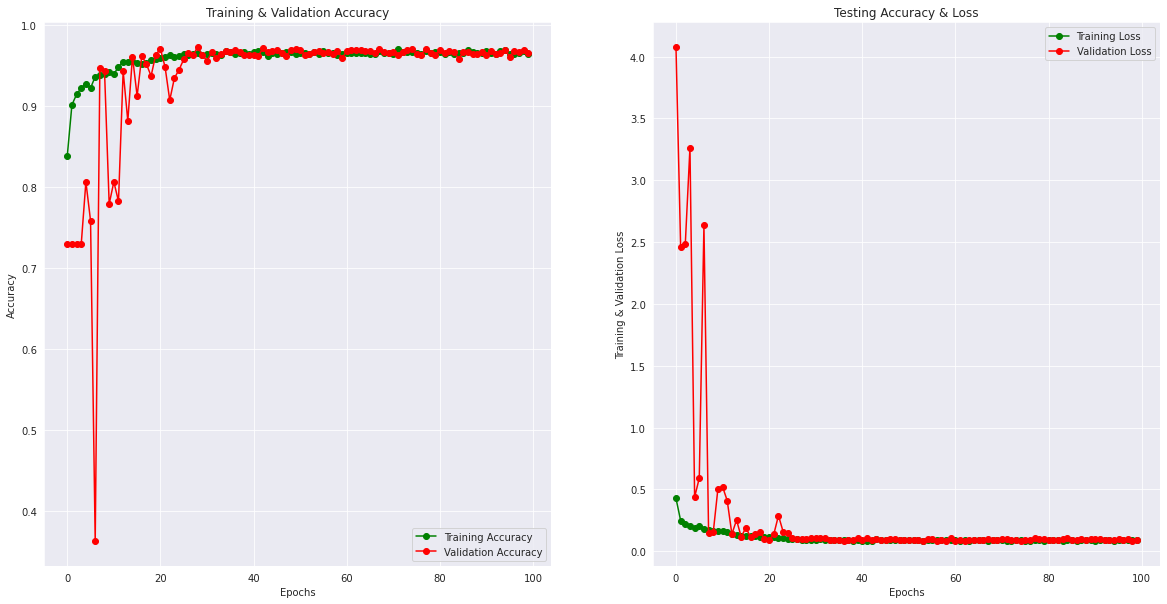

In [19]:
epochs = [i for i in range(epoch)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [20]:
#predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

19/19 [==============================] - 0s 6ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [21]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.92      0.96       428
   Normal (Class 1)       0.83      0.99      0.90       159

           accuracy                           0.94       587
          macro avg       0.91      0.96      0.93       587
       weighted avg       0.95      0.94      0.94       587



In [22]:
cm = confusion_matrix(y_test,predictions)
cm

array([[395,  33],
       [  1, 158]])

In [23]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

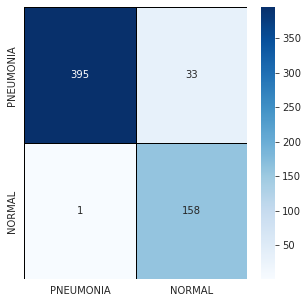

In [24]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [25]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [26]:
len(correct),len(incorrect)

(553, 34)

In [27]:
print("prediction score: ", len(correct)/(len(correct)+len(incorrect)))

prediction score:  0.9420783645655877


In [ ]:
i = 0
plt.figure(figsize=(16,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap="gray", interpolation='none')
    plt.title("Actual Class {}".format(y_test[i]))
    #plt.tight_layout()

In [ ]:
i = 0
plt.figure(figsize=(16,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap="gray", interpolation='none')
    plt.title("Actual Class {}".format(y_test[i]))
    #plt.tight_layout()

# result view & histogram

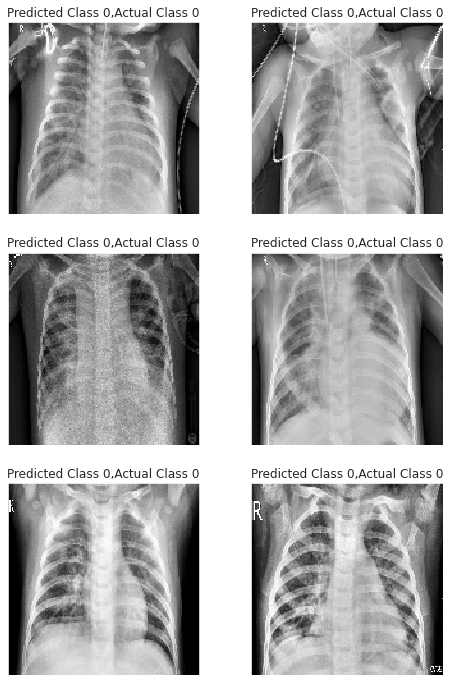

In [28]:
i = 0
plt.figure(figsize=(8,12))
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    #plt.tight_layout()
    i += 1

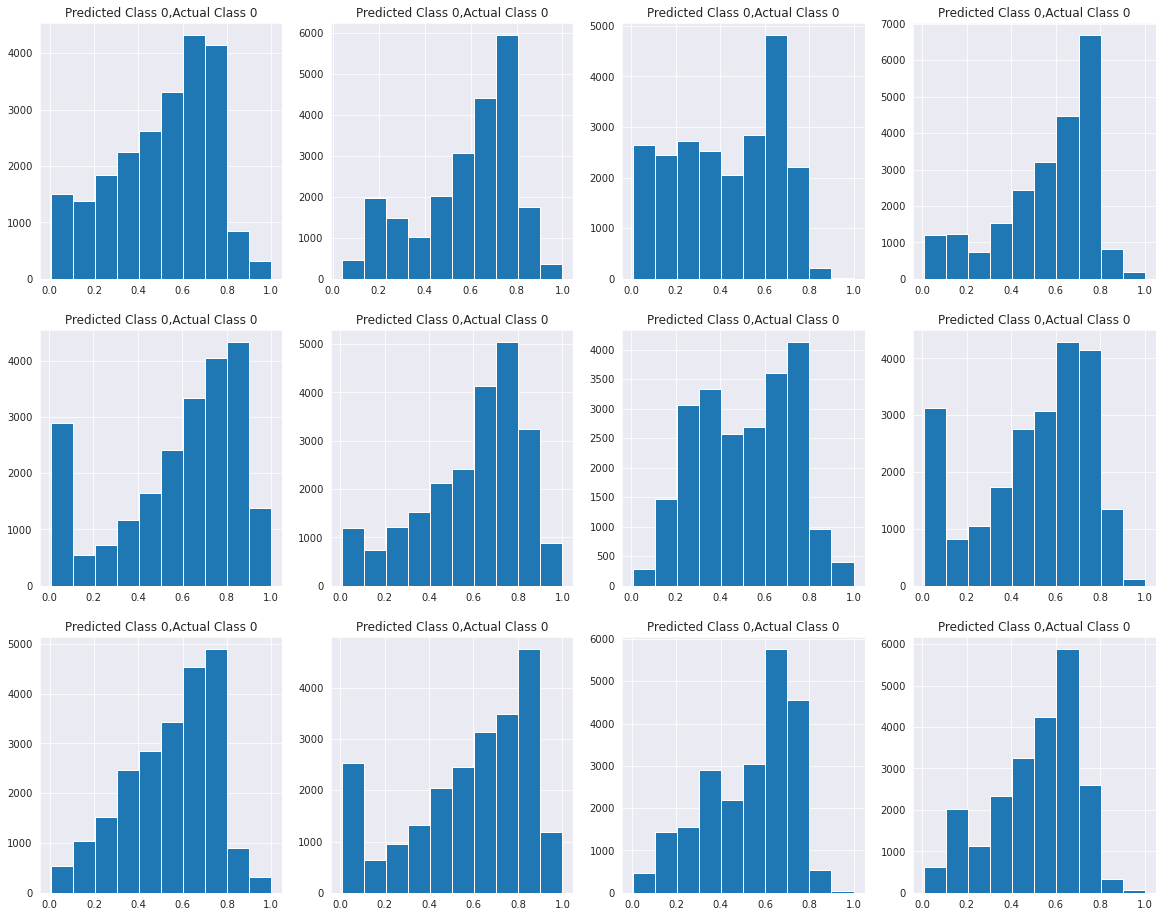

In [29]:
i = 0
plt.figure(figsize=(20,16))
for c in correct[:12]:
    plt.subplot(3,4,i+1)
    #histg = cv2.calcHist([c],[0],None,[256],[0,256]) 
    #plt.xticks([])
    #plt.yticks([])
    plt.hist(x_test[c].ravel())
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    #plt.tight_layout()
    i += 1

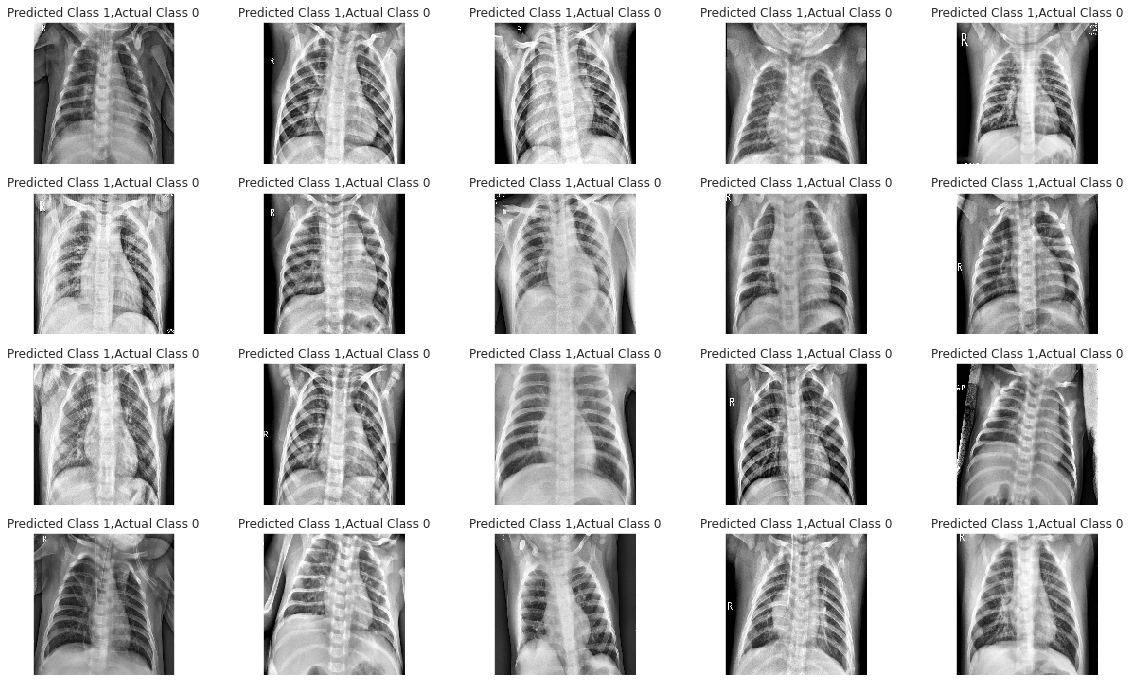

In [30]:
i = 0
plt.figure(figsize=(20,12))
for c in incorrect[:20]:
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    #plt.tight_layout()
    i += 1

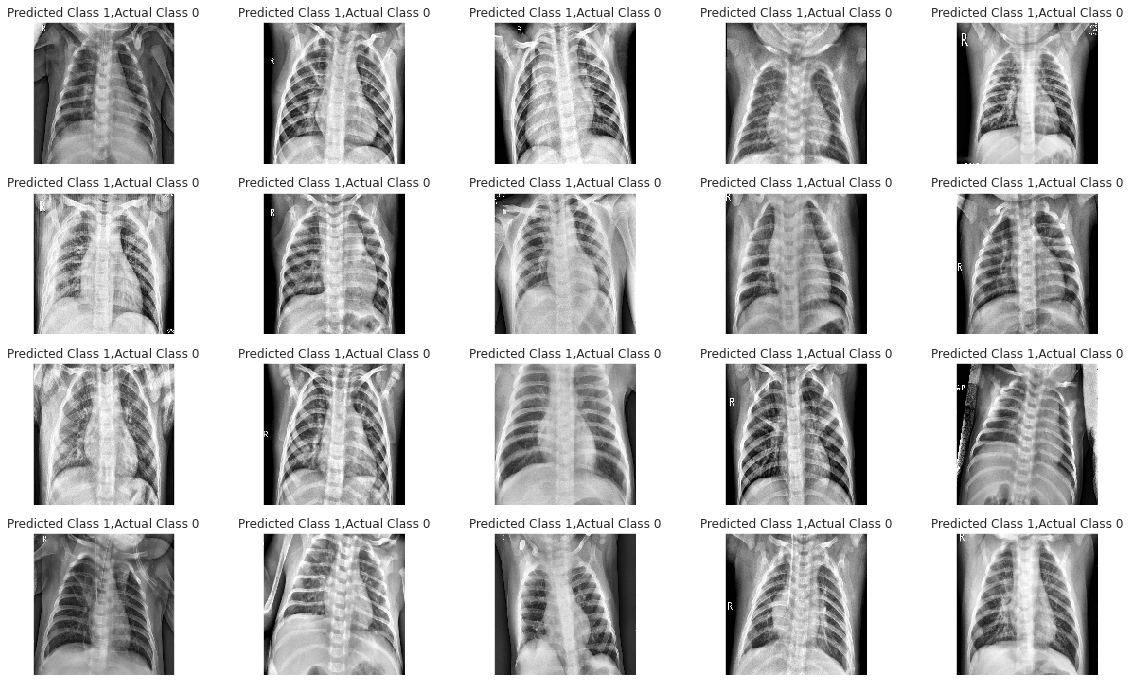

In [31]:
i = 0
plt.figure(figsize=(20,12))
for c in incorrect[:20]:
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    #plt.tight_layout()
    i += 1


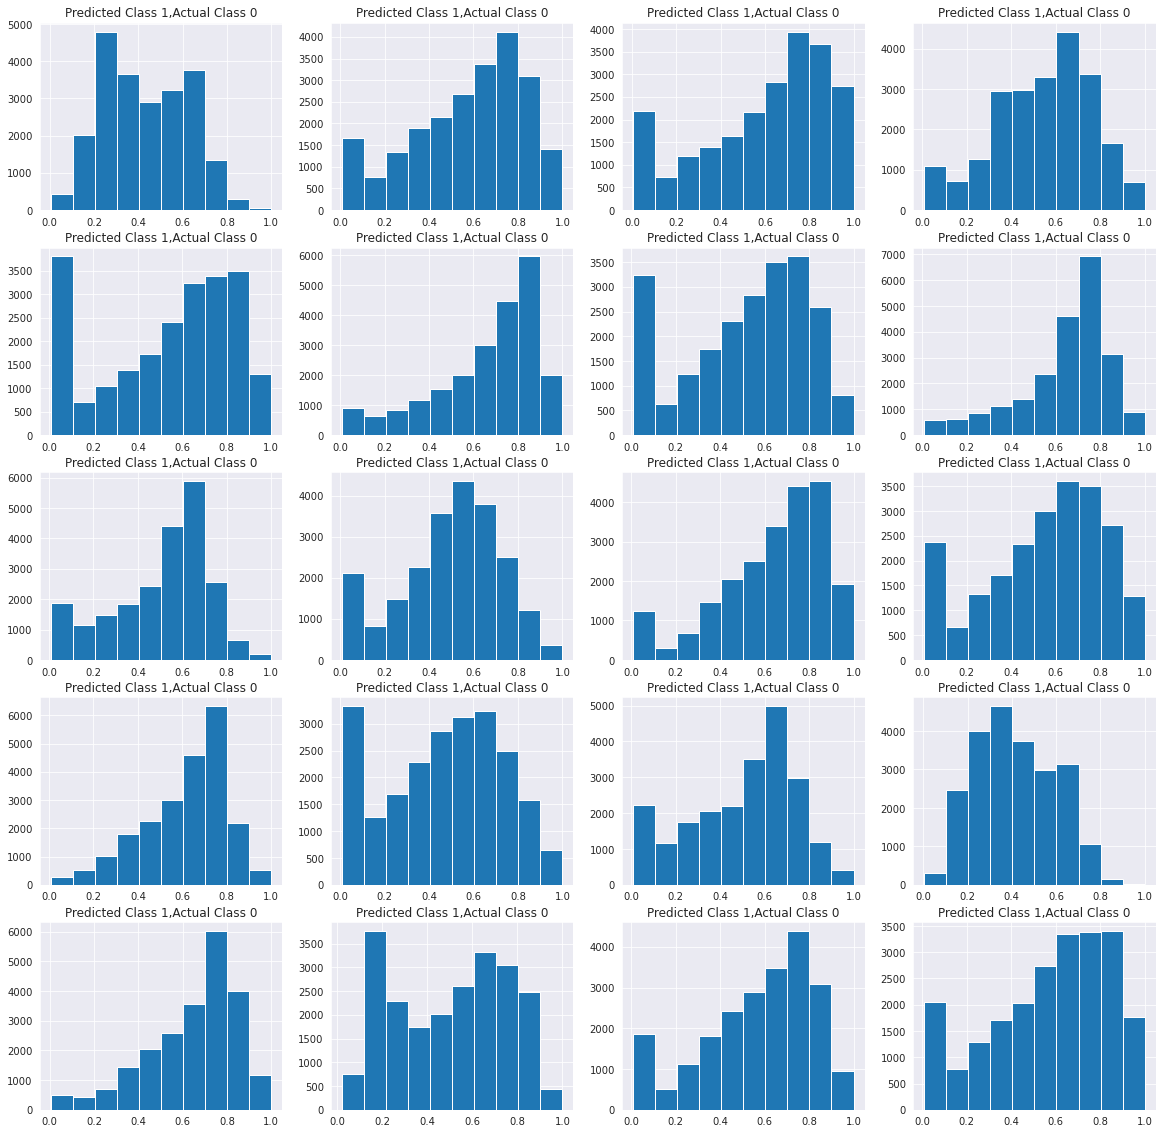

In [32]:
i = 0
plt.figure(figsize=(20,20))
for c in incorrect[:20]:
    plt.subplot(5,4,i+1)
    #histg = cv2.calcHist([c],[0],None,[256],[0,256]) 
    #plt.xticks([])
    #plt.yticks([])
    plt.hist(x_test[c].ravel())
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    #plt.tight_layout()
    i += 1

In [33]:
prd = (model.predict(x_test) > 0.5).astype("int32")
prd = prd.reshape(1,-1)[0]
cm = confusion_matrix(y_test,prd)
cm

19/19 [==============================] - 0s 8ms/step


array([[395,  33],
       [  1, 158]])

In [34]:
tp, fn, fp, tn = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn+fp)
specificity

0.9937106918238994

In [35]:
sensitivity = tp / (tp+fn)
sensitivity

0.9228971962616822

In [36]:
auc = metrics.roc_auc_score(y_test, predictions)
auc

0.9583039440427907

# saved model training

In [37]:
from keras.models import load_model
#model = load_model('best_model.epoch92-accuracy0.96.hdf5')
prd = (model.predict(x_test) > 0.5).astype("int32")
prd = prd.reshape(1,-1)[0]
cm = confusion_matrix(y_test,prd)
cm

19/19 [==============================] - 0s 7ms/step


array([[395,  33],
       [  1, 158]])

In [38]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

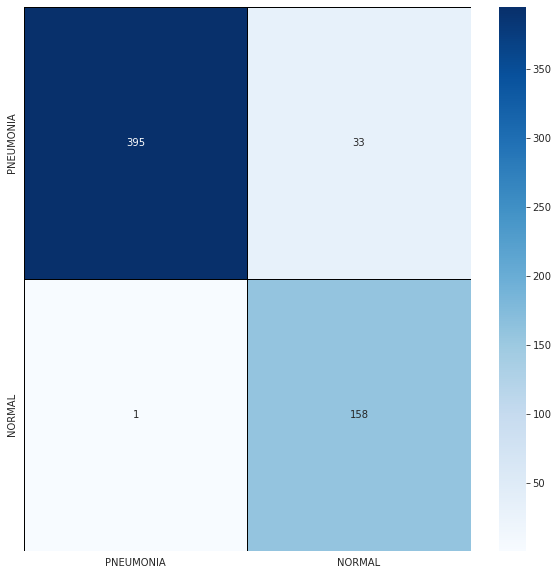

In [39]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

19/19 [==============================] - 0s 7ms/step


<Figure size 432x288 with 0 Axes>

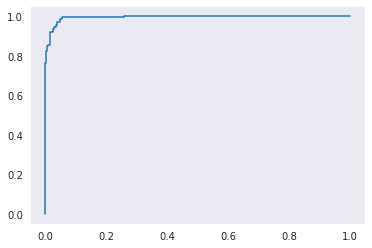

<Figure size 432x288 with 0 Axes>

In [40]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred=model.predict(x_test)
fpr,tpr,th =roc_curve(y_test,y_pred)
plt.plot(fpr,tpr,'-')
plt.grid(False)
plt.figure(facecolor=(0,0,0))

In [41]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [42]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (0)','Normal (1))']))

               precision    recall  f1-score   support

Pneumonia (0)       1.00      0.92      0.96       428
  Normal (1))       0.83      0.99      0.90       159

     accuracy                           0.94       587
    macro avg       0.91      0.96      0.93       587
 weighted avg       0.95      0.94      0.94       587



In [43]:
print("prediction score: ", len(correct)/(len(correct)+len(incorrect)))

prediction score:  0.9420783645655877


In [44]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# gradcam

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [46]:
from keras.models import load_model
#model = load_model('best_model.epoch90-accuracy0.96.hdf5')
prd = (model.predict(x_test) > 0.5).astype("int32")
prd = prd.reshape(1,-1)[0]
cm = confusion_matrix(y_test,prd)
cm

19/19 [==============================] - 0s 7ms/step


array([[395,  33],
       [  1, 158]])

In [47]:
#predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

19/19 [==============================] - 0s 7ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [48]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.92      0.96       428
   Normal (Class 1)       0.83      0.99      0.90       159

           accuracy                           0.94       587
          macro avg       0.91      0.96      0.93       587
       weighted avg       0.95      0.94      0.94       587



In [49]:
cm = confusion_matrix(y_test,predictions)
cm

array([[395,  33],
       [  1, 158]])

In [50]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

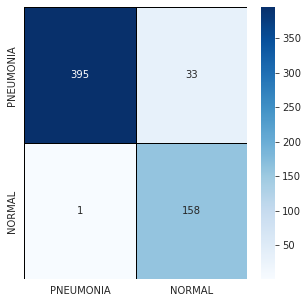

In [51]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [52]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [53]:
print("prediction score: ", len(correct)/(len(correct)+len(incorrect)))

prediction score:  0.9420783645655877


In [54]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [55]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [56]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.3, emphasize=emphasize)

  return superimposed


In [60]:
## Using the fuse_layers function, lets fuse together all layers in the model
img=x_test[29]
layer_name = 'conv2d_4'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.2, emphasize=False)
fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

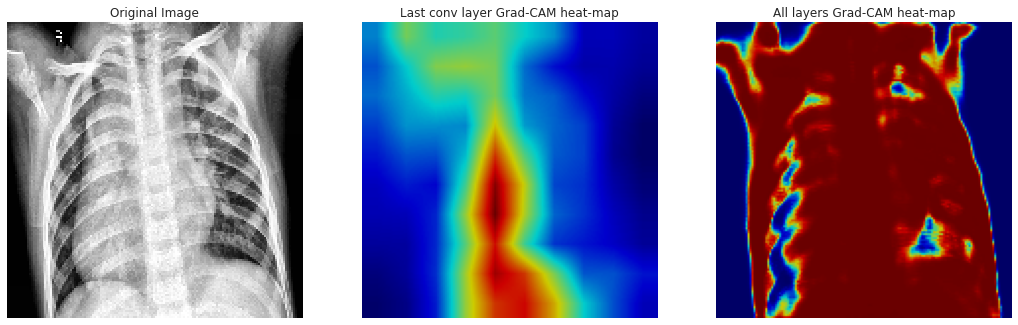

In [61]:
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img.reshape(img_size,img_size), cmap="gray", interpolation='none')
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last conv layer Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

0


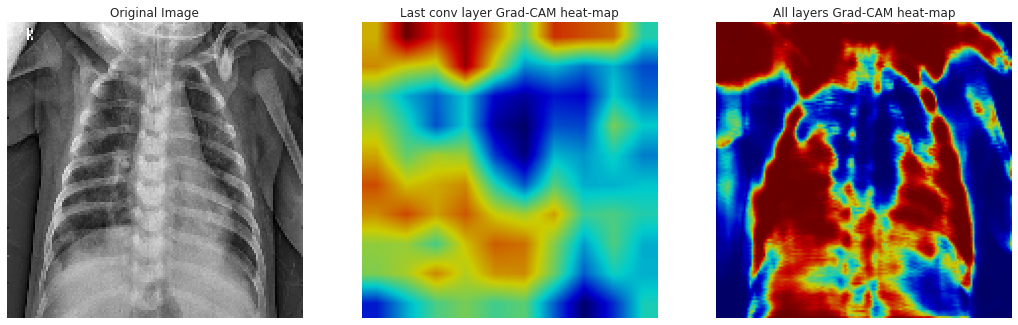

In [63]:
idx=incorrect[0]
img=x_test[idx]
layer_name = 'conv2d_4'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.2, emphasize=False)
fused = fuse_layers(all_layers, model, img, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img.reshape(img_size,img_size), cmap="gray", interpolation='none')
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last conv layer Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')
print(y_test[idx])

0


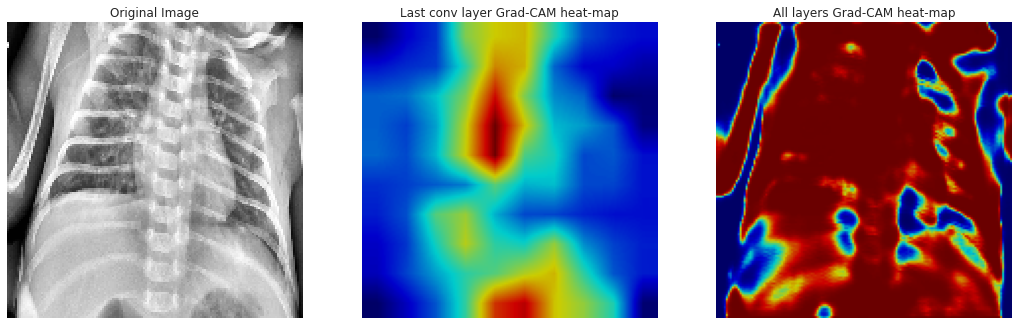

In [65]:
idx=incorrect[16]
img=x_test[idx]
layer_name = 'conv2d_4'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.2, emphasize=False)
fused = fuse_layers(all_layers, model, img, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img.reshape(img_size,img_size), cmap="gray", interpolation='none')
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last conv layer Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')
print(y_test[idx])

0


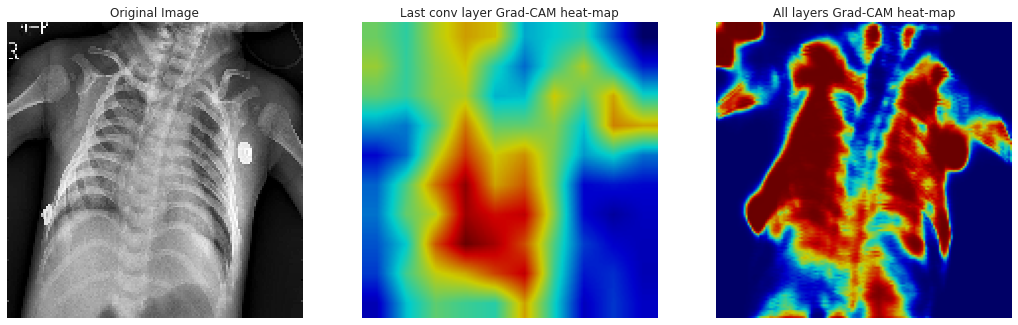

In [66]:
idx=correct[336]
img=x_test[idx]
layer_name = 'conv2d_4'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.2, emphasize=False)
fused = fuse_layers(all_layers, model, img, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img.reshape(img_size,img_size), cmap="gray", interpolation='none')
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last conv layer Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')
print(y_test[idx])

# gradcam from another source

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
model.summary()

In [ ]:
last_conv_layer_name = "conv2d_4"
classifier_layer_names = ["dense","dense_1"]

img_array=x_test[39]
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

